<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 21 - Transformers I
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

- Discuss the basic structure of the trasnformer model
- Talk about attention and how it works

## Where did we leave language processing? 

When we last talked about generating language, it was with recurrent neural networks: 

<img align="center" src="img/rnn-unfolded.png" width="800px" style="padding:30px;border:thin solid white;"> 


But there are problems with simple RNNs: 

- **Slow** - RNNs process data sequentially making them super slow. 
- **Vanishing gradient** -  RNNs (including LSTMs and GRUs) struggle with learning long range dependencies due to vanishing gradients. [1]  
- **Lack of attention** - RNNs process each word in order, and have difficulty with non-sequential dependencies. 

## Attention is all you need

In 2017, Ashish Vaswani and his colleagues at Google Research/Brain published their seminal work "Attention is all you need" [2]. In it, they introduce the transformer architecture which has become the foundation of every large language model since. So in this lecture, let's go through and try to decipher this architecture: 

<img align="center" src="img/Attention_is_all_you_need.png" width="400px" style="padding:30px;border:thin solid white;"> 


<img align="left" src="img/Attention_is_all_you_need_tokenization.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 1: Tokenization

We brushed on tokenization previously, but the basic idea is that you can segment language by letters, words, or something in between. What features you use can significantly impact your model's performance and structure.

<img align="center" src="img/tokenization_schemes.png" width="800px" style="padding:30px;border:thin solid white;"> 


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load a tiny GPT-2 model (small enough for CPU)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Make sure model is in eval mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

text = "The quick brown fox"
input_ids = tokenizer.encode(text)
tokens = tokenizer.tokenize(text)
words = [tokenizer.decode([id]) for id in input_ids]

print("Token IDs: ")
print(input_ids)
print("Tokens: ")
print(tokens)
print("Decoded tokens: ")
print(words)
print(f"Number of tokens: {len(tokens)}")

Token IDs: 
[464, 2068, 7586, 21831]
Tokens: 
['The', 'Ġquick', 'Ġbrown', 'Ġfox']
Decoded tokens: 
['The', ' quick', ' brown', ' fox']
Number of tokens: 4


| Concept | Explanation |
|:---|:---|
| Token $\neq$ Word | A word may be split into multiple tokens if it’s rare/complex. |
| Special Space Tokens | GPT-2 uses a `Ġ` (special marker) to represent leading spaces in tokens. |
| Number of tokens | Depends on how text is broken into subwords. |
| In this case | `"The quick brown fox"` tokenizes to

## Inference

How would we generate a totally new sequence from the transformer? 

First let's look at what we get when we insert a input sequence into the model:

In [26]:
input_ids = tokenizer.encode("The quick brown fox", return_tensors='pt').to('cpu')
print(input_ids)

# Forward pass through model
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits  # (batch_size, seq_length, vocab_size)
    
print(logits.shape)

tensor([[  464,  2068,  7586, 21831]])
torch.Size([1, 4, 50257])


## What do the logits represent?

You cna think of the logit matrix will be of the form: `[batch_size, sequence_length, vocab_size]`

Each slice `logits[:, i, :]` (for some $i$) represents the model’s prediction of what token should come next after the $i$-th token. 

Specifically:

- `logits[:, 0, :]` → predict what comes after the **first token**
- `logits[:, 1, :]` → predict what comes after the **second token**
- `logits[:, 2, :]` → predict what comes after the **third token**
- ...
- `logits[:, -1, :]` → predict what comes after the **very last token** you input

That's why when generating the next token, you only care about the last position — `logits[:, -1, :]`.

It’s predicting the next token based on the full context so far.


How do we generate a long sequence?

<img align="center" src="img/inference_diagram.png" width="800px" style="padding:30px;border:thin solid white;"> 

So let's generate a long sequence. 

In [27]:
def generate_step(model, tokenizer, input_text, device='cpu'):
    """
    Given the current input_text, run one generation step.
    - Return updated text
    - Return top 10 next-token candidates (token, probability)
    """
    # Tokenize input
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

    # Forward pass through model
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits  # (batch_size, seq_length, vocab_size)

    # Focus on the last token's logits
    next_token_logits = logits[:, -1, :].squeeze(0)  # (vocab_size,)

    # Convert logits to probabilities
    probs = torch.softmax(next_token_logits, dim=-1)

    # Get top 10 most probable tokens
    top_probs, top_indices = torch.topk(probs, 10)

    # Decode top tokens
    top_tokens = [tokenizer.decode(idx.item()) for idx in top_indices]

    # Greedy choice: pick the token with the highest probability
    next_token_id = top_indices[0].unsqueeze(0)
    next_token = tokenizer.decode(next_token_id)

    # Append the new token to the existing text
    updated_text = input_text + next_token

    # Prepare top 10 as a list of (token, probability) pairs
    top_10 = [(token, prob.item()) for token, prob in zip(top_tokens, top_probs)]

    return updated_text, top_10

In [29]:
# Initial prompt
text = "The meaning of life is"

# Generation steps
for _ in range(5):
    text, top_10 = generate_step(model, tokenizer, text)
    print("Top 10 next tokens:")
    for token, prob in top_10:
        print(f"{token!r} ({prob:.4f})")
    print(f"Updated Text: {repr(text)}\n")
    print("\n" + "-"*50 + "\n")


Top 10 next tokens:
' to' (0.1513)
' not' (0.0890)
' a' (0.0650)
' that' (0.0557)
' the' (0.0513)
' defined' (0.0199)
' an' (0.0157)
',' (0.0153)
' one' (0.0118)
' in' (0.0112)
Updated Text: 'The meaning of life is to'


--------------------------------------------------

Top 10 next tokens:
' be' (0.2613)
' live' (0.0408)
' say' (0.0191)
' have' (0.0159)
' make' (0.0149)
' give' (0.0130)
' know' (0.0123)
' find' (0.0119)
' the' (0.0110)
' take' (0.0099)
Updated Text: 'The meaning of life is to be'


--------------------------------------------------

Top 10 next tokens:
' understood' (0.0404)
' able' (0.0314)
' a' (0.0283)
' lived' (0.0276)
' the' (0.0231)
' found' (0.0166)
' determined' (0.0162)
' seen' (0.0150)
' defined' (0.0135)
' in' (0.0130)
Updated Text: 'The meaning of life is to be understood'


--------------------------------------------------

Top 10 next tokens:
' as' (0.2249)
' in' (0.1128)
' and' (0.0959)
' by' (0.0883)
',' (0.0871)
'.' (0.0610)
' to' (0.0374)
' through

Any guesses what the meaning of life is to DistilGPT2?

In [18]:
def generate_n_tokens(model, tokenizer, input_text, n_tokens=5, device='cpu', verbose=True):
    """
    Generate `n_tokens` tokens from input_text using greedy decoding.
    - verbose=True prints generation steps
    - returns the final updated text
    """
    text = input_text

    for i in range(n_tokens):
        text, top_10 = generate_step(model, tokenizer, text, device=device)

        if verbose:
            print(f"Step {i+1}:")
            print(f"Updated Text: {repr(text)}\n")
            print("Top 10 next tokens:")
            for token, prob in top_10:
                print(f"{token!r} ({prob:.4f})")
            print("\n" + "-"*50 + "\n")

    return text

In [22]:
start_text = "The meaning of life is to"
final_text = generate_n_tokens(model, tokenizer, start_text, n_tokens=20, verbose=False)
print("Final generated text:\n", final_text)

Final generated text:
 The meaning of life is to be understood as a whole, and to be understood as a whole, and to be understood as a


## Embeddings

Recall the PCA lecture where we extracted the principal components of the MNIST dataset and plotted the different MNIST images in a two-dimensional plot: 

<img align="center" src="img/MNIST_PCA_plot.png" width="800px" style="padding:30px;border:thin solid white;"> 

We are effectively storign information about the images as a two-dimensional vector. This is called **embedding**. We as embedded the images as a two-dimensional vector. 

Consider the encoder-decoder scheme of the image segmentation network: 

<img align="center" src="img/autoencoder-example.png" width="800px" style="padding:30px;border:thin solid white;"> 

IN the encoder part of the network, we go from a large image to small matrix. That small matrix contains the semantic information describing the image. We effectively **embed** the image as that small matrix. 


### Embedding words

Embedding a word is pretty much the same idea. The natwork wants to store that symbol as a vector and the direction of the vector encodes some semantic information about the word. 

<img align="center" src="img/analogy_visual.png" width="800px" style="padding:30px;border:thin solid white;"> 

What's interesting is that if the embedding is done well, the relative position between embeddings is itself a embedding and contains some semantic information! We can see this is code by analyzing one of the OG embedding schemes GLoVe embeddings: 

In [5]:
import gensim.downloader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the GloVe 50-dimensional model
model = gensim.downloader.load("glove-wiki-gigaword-50")

# 1. Basic embedding lookup
word = "tower"
vector = model[word]
print(f"Embedding for '{word}':\n{vector}\n")

# 2. Embedding math: analogy task (king - man + woman ≈ queen)
result_vector = model["king"] - model["man"] + model["woman"]

# Find closest word to result_vector
similar_words = model.similar_by_vector(result_vector, topn=5)
print("Closest words to 'king - man + woman':")
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")

print()

# 3. Cosine similarity between two words
def cosine_sim(w1, w2):
    v1 = model[w1].reshape(1, -1)
    v2 = model[w2].reshape(1, -1)
    return cosine_similarity(v1, v2)[0][0]

sim = cosine_sim("king", "queen")
print(f"Cosine similarity between 'king' and 'queen': {sim:.3f}")

sim2 = cosine_sim("tower", "building")
print(f"Cosine similarity between 'tower' and 'building': {sim2:.3f}")

print()

# 4. Create a custom vector (mix two concepts) and find nearby words
custom_vector = (model["river"] + model["mountain"]) / 2
similar_words = model.similar_by_vector(custom_vector, topn=5)
print("Words similar to average of 'river' and 'mountain':")
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")

Embedding for 'tower':
[ 1.1474e+00  1.1811e+00  7.4556e-01 -5.9101e-02  5.0499e-01 -7.0449e-01
 -3.2136e-01 -4.5390e-01 -4.5763e-01 -7.5341e-01 -3.3511e-01 -2.4975e-02
 -5.0192e-01  6.3773e-01 -8.3059e-01  8.3565e-01 -2.4701e-01  3.2421e-01
 -1.1103e+00 -2.1335e-02  6.8717e-01 -3.9340e-01 -1.6390e+00 -5.0493e-01
 -1.6684e-01 -6.7649e-01 -3.1798e-01  8.8503e-01 -3.1552e-02 -1.5608e-01
  1.9805e+00 -1.1870e+00  8.3342e-01 -1.8369e-01 -2.6691e-01  1.1619e-01
  1.1023e+00 -3.5937e-01  2.5015e-02 -4.0615e-02  3.0681e-01 -4.1076e-01
  8.4586e-02  2.2475e-01 -5.0955e-01  6.5819e-01 -1.2432e-01 -1.4039e+00
  1.6178e-04 -5.2529e-01]

Closest words to 'king - man + woman':
  king: 0.886
  queen: 0.861
  daughter: 0.768
  prince: 0.764
  throne: 0.763

Cosine similarity between 'king' and 'queen': 0.784
Cosine similarity between 'tower' and 'building': 0.787

Words similar to average of 'river' and 'mountain':
  river: 0.932
  mountain: 0.898
  valley: 0.896
  mountains: 0.858
  creek: 0.846


The important thing to remember is that computer accepts numbers, not symbols. So let's assume word tokenization. We need to embed the words as n-dimensional vectors. 

<img align="center" src="img/input_embedding.png" width="800px" style="padding:30px;border:thin solid white;"> 

* remember, the embedding matrix is trainable. Just another set of parameters that needs to be train of thousands of iterations on large datasets

<img align="left" src="img/Attention_is_all_you_need_positional_encoding.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 2: Positional encoding

**Core concept:** We want to give the model a method to reference a word at a particular positon in the sentence.

**Some nuances:** 

- We want each word to carry information about its position in the sentence
- We want words that are close together to have similar positional encodings and the words that are far apart to have dissimilar position encodings. 
- Needs to be something that the model can learn. 
- Would be nice to only encode the encodings once (so no variable encodings for each sentence) 

<img align="left" src="img/positional_encoding.png" width="800px" style="padding:30px;border:thin solid white;"> 


### Sinusoidal Positional Encoding - (Vaswani et al., 2017)

<img align="right" src="img/positional_encoding_2.png" width="300px" style="padding:30px;border:thin solid white;"> 



In the original Transformer paper ("Attention is All You Need"), **fixed sinusoidal functions** were used:

For a position $pos$ and dimension $i$, the encoding is defined as:

$$
\text{PE}^0_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

$$
\text{PE}^1_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

Where:
- $pos$ = position in the sequence
- $i$ = embedding dimension index
- $d_{\text{model}}$ = total embedding size (e.g., 512)

**Even dimensions** → sine  
**Odd dimensions** → cosine

### Intuition:
- Different frequencies allow each position to be uniquely encoded.
- Nearby positions have similar encodings (smooth changes).
- Generalizes to sequences **longer** than what the model was trained on.

### Conceptual explanation

I found a [blog post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) that gives the best explanation so far about why the positonal encodings are formulated the way they are. Here's the cliff notes: 

We need a positional encoding that satisfies the realtive criteria: 
- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.


#### Why sines and cosines? 

Suppose we want to represent a number in binary format: 

|   | Bit 3 | Bit 2 | Bit 1 | Bit 0 |   | Bit 3 | Bit 2 | Bit 1 | Bit 0 |
|:-:|:----:|:----:|:----:|:----:|:-:|:----:|:----:|:----:|:----:|
|  0 |  0 | 0 | 0 | 0 | 8 | 1 | 0 | 0 | 0 |
|  1 |  0 | 0 | 0 | 1 | 9 | 1 | 0 | 0 | 1 |
|  2 |  0 | 0 | 1 | 0 | 10 | 1 | 0 | 1 | 0 |
|  3 |  0 | 0 | 1 | 1 | 11 | 1 | 0 | 1 | 1 |
|  4 |  0 | 1 | 0 | 0 | 12 | 1 | 1 | 0 | 0 |
|  5 |  0 | 1 | 0 | 1 | 13 | 1 | 1 | 0 | 1 |
|  6 |  0 | 1 | 1 | 0 | 14 | 1 | 1 | 1 | 0 |
|  7 |  0 | 1 | 1 | 1 | 15 | 1 | 1 | 1 | 1 |

Each bit position has a different frequency. That is pretty much what we're doing with the positonal vectors above representng the dimension and pos as frequencies. 

#### Relative positioning

The other benefit is that we can calculate relative postioning fairly easily:

$$
M \cdot 
\begin{bmatrix}
\sin(\omega_k t) \\
\cos(\omega_k t)
\end{bmatrix}
=
\begin{bmatrix}
\sin(\omega_k (t + \phi)) \\
\cos(\omega_k (t + \phi))
\end{bmatrix}
$$

---

**Proof:**

Let $M$ be a $2 \times 2$ matrix, we want to find $u_1, v_1, u_2$ and $v_2$ so that:

$$
\begin{bmatrix}
u_1 & v_1 \\
u_2 & v_2
\end{bmatrix}
\cdot
\begin{bmatrix}
\sin(\omega_k t) \\
\cos(\omega_k t)
\end{bmatrix}
=
\begin{bmatrix}
\sin(\omega_k (t + \phi)) \\
\cos(\omega_k (t + \phi))
\end{bmatrix}
$$

By applying the [addition theorem](https://en.wikipedia.org/wiki/Trigonometric_identities#Angle_sum_and_difference_identities), we can expand the right-hand side as follows:

$$
\begin{bmatrix}
u_1 & v_1 \\
u_2 & v_2
\end{bmatrix}
\cdot
\begin{bmatrix}
\sin(\omega_k t) \\
\cos(\omega_k t)
\end{bmatrix}
=
\begin{bmatrix}
\sin(\omega_k t) \cos(\omega_k \phi) + \cos(\omega_k t) \sin(\omega_k \phi) \\
\cos(\omega_k t) \cos(\omega_k \phi) - \sin(\omega_k t) \sin(\omega_k \phi)
\end{bmatrix}
$$

Which results in the following two equations:

$$
u_1 \sin(\omega_k t) + v_1 \cos(\omega_k t) = \cos(\omega_k \phi) \sin(\omega_k t) + \sin(\omega_k \phi) \cos(\omega_k t) \tag{1}
$$

$$
u_2 \sin(\omega_k t) + v_2 \cos(\omega_k t) = -\sin(\omega_k \phi) \sin(\omega_k t) + \cos(\omega_k \phi) \cos(\omega_k t) \tag{2}
$$

By solving the above equations, we get:

$$
u_1 = \cos(\omega_k \phi) \quad v_1 = \sin(\omega_k \phi)
$$

$$
u_2 = -\sin(\omega_k \phi) \quad v_2 = \cos(\omega_k \phi)
$$

---

Thus, the final transformation matrix $M$ is:

$$
M_{\phi,k} =
\begin{bmatrix}
\cos(\omega_k \phi) & \sin(\omega_k \phi) \\
-\sin(\omega_k \phi) & \cos(\omega_k \phi)
\end{bmatrix}
$$

**This is likely why sine/cosine are both used**. There isn't a clear linear transformation with only sine or only cosine.  

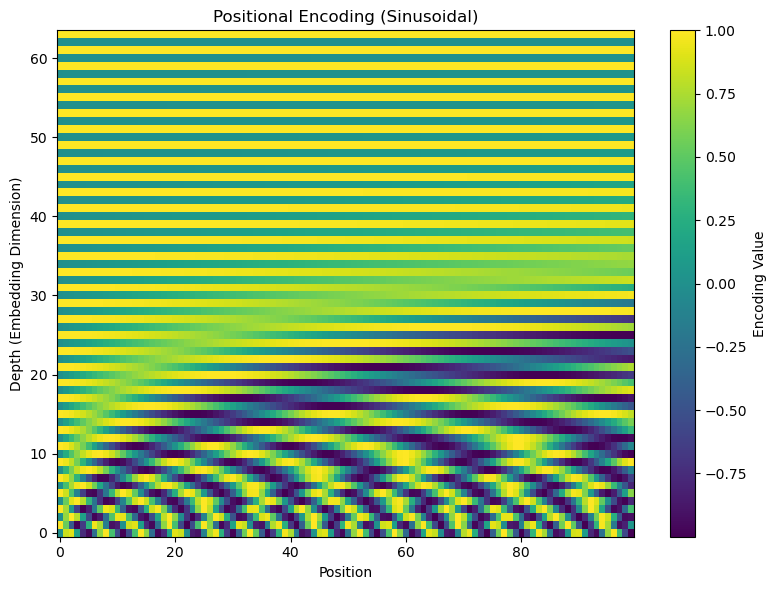

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_positional_encoding(seq_len=100, d_model=64, save_path=None):
    """
    Plots the positional encoding and optionally saves the figure.
    
    Args:
        seq_len (int): Number of positions (x-axis).
        d_model (int): Embedding depth (y-axis).
        save_path (str, optional): If provided, saves the figure to this path.
    """
    def get_sinusoidal_encoding(seq_len, d_model):
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
        angle_rads = pos * angle_rates

        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return pos_encoding

    pos_encoding = get_sinusoidal_encoding(seq_len, d_model)

    plt.figure(figsize=(8, 6))
    plt.imshow(pos_encoding.T, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Encoding Value')
    plt.xlabel('Position')
    plt.ylabel('Depth (Embedding Dimension)')
    plt.title('Positional Encoding (Sinusoidal)')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# Example usage:
plot_positional_encoding(seq_len=100, d_model=64, save_path=None)  # Show figure
# plot_positional_encoding(seq_len=100, d_model=64, save_path='positional_encoding.png')  # Save figure

### Why is Positional Encoding a Function of Sin/Cos?

When designing the Transformer (Vaswani et al., 2017), the key challenge was:

> Transformers have no recurrence and no convolution — how do we tell the model the order of tokens?

#### Core Reasons for Using Sinusoids

1. Captures Relative and Absolute Position

- Sinusoids are smooth and periodic.
- They encode both:
  - **Absolute position**: Each position gets a unique vector.
  - **Relative distance**: Easy to infer how far apart two positions are.

Note: 
$$
\sin(a + b) = \sin(a)\cos(b) + \cos(a)\sin(b)
$$
Thus, the model can **easily compute relative offsets** based on the sin/cos values.

2. No Extra Parameters

- Sinusoidal functions are **fixed** — no extra weights to learn.
- Transformer can **extrapolate** to longer sequences during inference without retraining.

3. Multi-Scale Representations

- Different dimensions have different frequencies:
  - Low-frequency sinusoids capture **long-range** patterns.
  - High-frequency sinusoids capture **local** patterns.

> "We use sine and cosine functions of different frequencies. For each position, we generate a vector whose even indices are sine functions and whose odd indices are cosine functions of different wavelengths."

This lets the model attend both to **nearby** and **distant** tokens effectively.

---

#### There are other position encoding schemes: 

> "There are many choices of positional encodings, learned and fixed ... We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results"

<img align="left" src="img/Attention_is_all_you_need_attention.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 3: Multi-head Attention

(Specifically self-attention, other types of attention next time)


<img align="right" src="img/attention_example.png" width="500px" style="padding:30px;border:thin solid white;"> 


**Attention** is a mechanism that allows the model to **focus** on different parts of the input when producing each output.

In the original transformer paper [1], **Scaled Dot-Product Attention** is used:

Given:
- Query vector: $Q$
- Key vector: $K$
- Value vector: $V$

the attention output is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$

---
### Key Steps:

1. **Compute Scores**:  
   Measure similarity between Query ($Q$) and Key ($K$) by dot product: $QK^\top$

2. **Scale Scores**:  
   Divide by $\sqrt{d_k}$ (dimension of keys) to prevent extremely large values.

3. **Apply Softmax**:  
   Convert scores into probabilities that sum to 1.

4. **Weighted Sum**:  
   Multiply softmax weights by the Values ($V$).

---
### Intuition:
- Query asks: *"What am I related to?"*
- Keys tell: *"What components of the sequence are relevant to the duery?"*
- Values deliver: *"Let's add add relevant words together so each vector contains the orginal word embedding values plus information about the relevant words near it."*

---

### Example of self-attention

<img align="left" src="img/attention_paper_example_2.png" width="800px" style="padding:30px;border:thin solid white;"> 

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


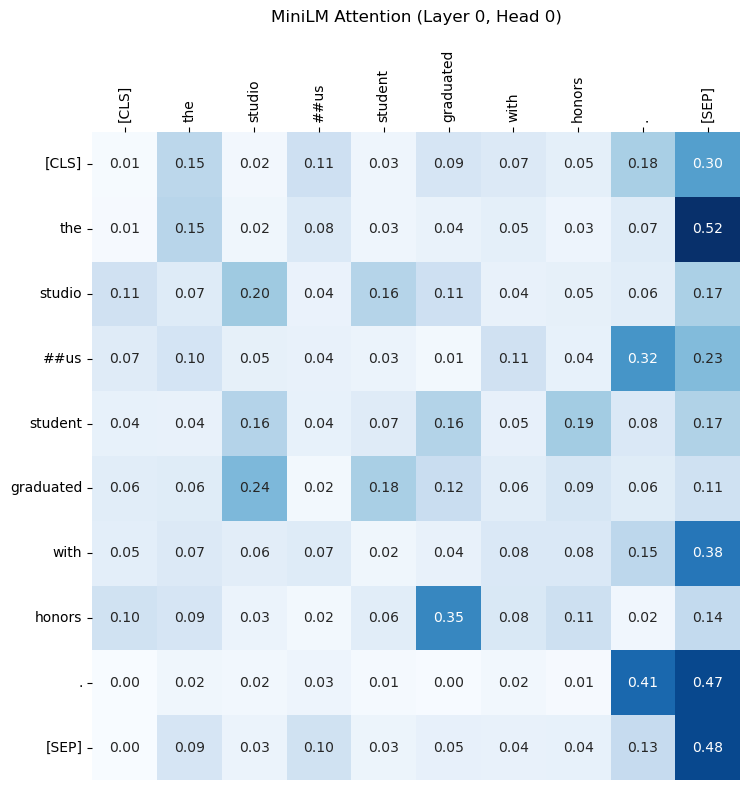

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correct model
tokenizer = AutoTokenizer.from_pretrained("nreimers/MiniLM-L6-H384-uncased")
model = AutoModel.from_pretrained("nreimers/MiniLM-L6-H384-uncased", output_attentions=True)

# Tokenize input
text = "The studious student graduated with honors."
inputs = tokenizer(text, return_tensors="pt")

# Forward pass
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

# Pick a layer and head
layer_idx = 0
head_idx = 0
attention_matrix = attentions[layer_idx][0, head_idx].detach().cpu().numpy()

# Tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Make DataFrame
attention_df = pd.DataFrame(attention_matrix, index=tokens, columns=tokens)

# Plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(attention_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title(f"MiniLM Attention (Layer {layer_idx}, Head {head_idx})", pad=20)
plt.tight_layout()
plt.show()

### Some notes about attention: 

- We expect the values along the diagonal to be the largest (because a word is most relevant to itself) 
- Up until now we've used no parameters (though that's about to change)

- What are `[CLS]` and `[SEP]` tokens?

| Token | Stands for | Meaning |
|:---|:---|:---|
| `[CLS]` | **Classification** token | Special token added at the **beginning** of every input sequence. Used to summarize the sentence. |
| `[SEP]` | **Separator** token | Special token used to **separate different segments** (like sentence A and B). Also marks the **end** of a single sentence. |


### Multi-Head Attention

Instead of applying a single attention function, Transformers use **Multi-Head Attention**.

---
### How Multi-Head Attention Works:

1. **Project** Queries, Keys, and Values into multiple subspaces:
   - Each head gets different $Q$, $K$, $V$ through learned linear transformations.

2. **Apply Attention** independently in each head.

3. **Concatenate** the outputs of all heads.

4. **Final Linear Layer** combines the concatenated heads.

---
### Mathematically:

For each head:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

Then:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$



<img align="left" src="img/multi_head_attention_overview.png" width="800px" style="padding:30px;border:thin solid white;"> 

[3]

### Example of multi-head attention

<img align="left" src="img/attention_paper_example_3.png" width="800px" style="padding:30px;border:thin solid white;"> 

---
### Why Multi-Head Attention?

- Each head can **focus on different relationships** (short-term, long-term, positional, syntactic).
- Allows model to **capture richer patterns**.

---
### Question for you

- What's the point of splitting the matrices up and then recombining them? Why not just do one large self-attention?
 


<img align="left" src="img/Attention_is_all_you_need_encoder.png" width="250px" style="padding:30px;border:thin solid white;"> 


## Step 4: Normalize and more Linear layers

After the Multi-Head Attention block, the Transformer applies two critical operations:

---

### 1. Add & Norm (Residual Connection + Layer Normalization)

- **Residual Connection**:
  - Adds the original input of the attention block to its output.
  
  $$
  \text{Residual} = \text{Input} + \text{AttentionOutput}
  $$

- **Layer Normalization**:
  - Normalizes across feature dimensions to stabilize and accelerate training.

  $$
  \text{NormedOutput} = \text{LayerNorm}(\text{Residual})
  $$

- Helps prevent vanishing/exploding gradients.  
- Allows smoother gradient flow through the network.

---

### 2. Position-wise Feed-Forward Network (FFN)

- Applies the **same small MLP** to each token individually.

  $$
  \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
  $$

  - $W_1$, $W_2$ are weight matrices.
  - First linear layer expands the dimension (e.g., from $d_{\text{model}}$ to 4×$d_{\text{model}}$).
  - ReLU non-linearity.
  - Second linear layer projects back to $d_{\text{model}}$.

- Introduces non-linearity and richer transformations.  
- Same FFN weights are shared across all sequence positions.

<img align="left" src="img/Attention_is_all_you_need.png" width="250px" style="padding:30px;border:thin solid white;"> 


## Decoder

We have seen the components of the decoder but there are a few subtle variations: 

- Masked attention
- Un-equal Q,K,V matrices

### Masked Multi-Head Attention

Masked Multi-Head Attention is used in the Transformer **decoder** to **prevent attending to future tokens** during training.

---

#### Purpose:  
- During training, the model should **only use known (past) tokens** to predict the next token.
- It **must not "cheat"** by looking ahead at future tokens.

---
<img align="right" src="img/attention_masked_example.png" width="350px" style="padding:30px;border:thin solid white;"> 

#### How It Works:

- Before applying the softmax to the attention scores $QK^\top$, 
- **Mask out** (set to $-\infty$) all connections to **future tokens**.
- After masking:
  - Softmax assigns **zero probability** to any future token.

---

#### Mathematically:

$$
\text{MaskedAttention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top + M}{\sqrt{d_k}} \right)V
$$

Where:
- $M$ = Mask matrix:
  - $0$ for allowed connections (past and current tokens),
  - $-\infty$ for disallowed (future tokens).

/Users/nickvashkani/anaconda3/envs/ece364_oldnb_rise/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  f"`return_dict_in_generate` is not `True`, `{extra_output_flag}` is ignored.",


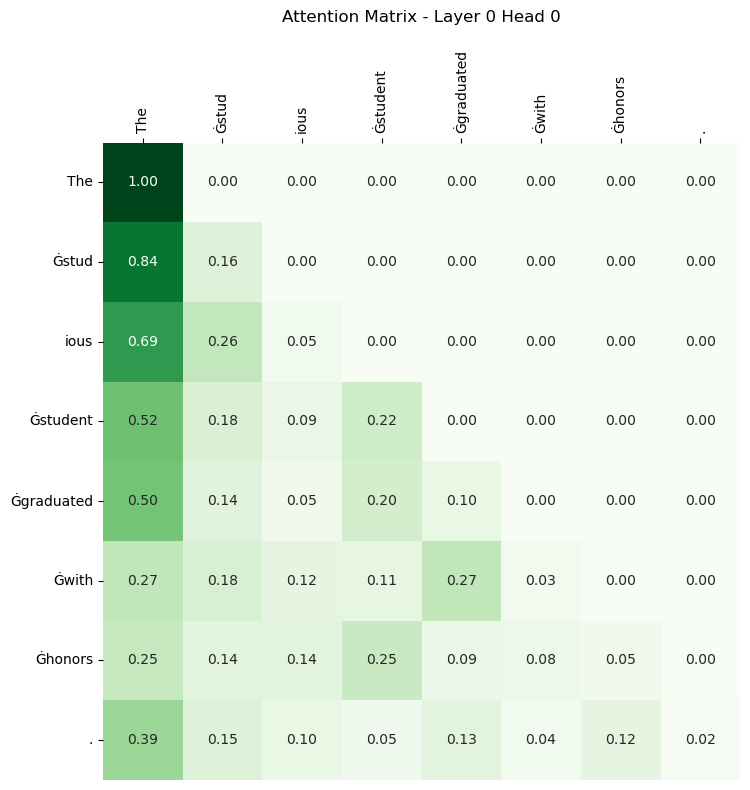

In [21]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

# Step 1: Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2", output_attentions=True)

# Step 2: Tokenize input
text = "The studious student graduated with honors."
inputs = tokenizer(text, return_tensors="pt")

# Step 3: Forward pass to get attentions
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

# Step 4: Select layer and head
layer_idx = 0
head_idx = 0
attention_matrix = attentions[layer_idx][0, head_idx].detach().cpu().numpy()

# Step 5: Decode tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Step 6: Build square dataframe
attention_df = pd.DataFrame(attention_matrix, index=tokens, columns=tokens)

# Step 7: Plot without offset
plt.figure(figsize=(10, 8))
ax = sns.heatmap(attention_df, annot=True, fmt=".2f", cmap="Greens", cbar=False, square=True)

# Fix the ticks so row and column labels align
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Move x-axis labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title(f"Attention Matrix - Layer {layer_idx} Head {head_idx}", pad=20)
plt.tight_layout()
plt.show()

In [23]:
# This will be useful later: 
print(f"Number of layers: {len(model.transformer.h)}")
print(f"Number of attention heads per layer: {model.config.n_head}")

Number of layers: 6
Number of attention heads per layer: 12


### Cross-Attention in Transformer Decoder

Cross-Attention connects the **decoder** to the **encoder outputs**.

---
<img align="right" src="img/Attention_is_all_you_need.png" width="350px" style="padding:30px;border:thin solid white;"> 

#### Purpose:

- Enables the decoder to **attend to the full encoded input sequence**.
- Essential for **sequence-to-sequence** tasks (e.g., translation, summarization).
- Allows the decoder to gather **relevant information** from the source input at every step.

---

#### How It Works:

- **Queries ($Q$)** come from the **decoder's previous layer**.
- **Keys ($K$)** and **Values ($V$)** come from the **encoder outputs** (fixed).
  
Thus:

$$
\text{CrossAttention}(Q_{\text{decoder}}, K_{\text{encoder}}, V_{\text{encoder}})
$$

---
#### Full Step-by-Step:

1. **Input**: Decoder hidden states (as queries), Encoder outputs (as keys and values).
2. **Compute Attention Scores**: Compare decoder queries with encoder keys.
3. **Softmax over Scores**: Determine relevance of each encoder token to the current decoder token.
4. **Weighted Sum of Encoder Values**: Aggregate useful information from the encoder.


## Training

Training a Transformer model involves teaching it to **predict outputs** from inputs using **supervised learning**.

---

<img align="right" src="img/training.png" width="450px" style="padding:30px;border:thin solid white;"> 

### Core Idea:

- The Transformer learns to **minimize a loss function** that measures the difference between its **predicted outputs** and the **ground-truth targets**.
- Training is done **end-to-end** with **gradient descent**.

---

## 🚀 Training Steps:

1. **Input Preparation**:
   - Encoder receives the **input sequence** (e.g., source sentence).
   - Decoder receives the **target sequence shifted right** (teacher forcing).

2. **Forward Pass**:
   - Encoder outputs hidden states.
   - Decoder generates predictions **token-by-token**, attending to encoder outputs (via cross-attention).

3. **Loss Computation**:
   - Compare decoder predictions to ground truth using a loss function, typically **cross-entropy loss**.

4. **Backward Pass**:
   - Compute gradients of the loss with respect to all model parameters (weights).
   - Backpropagate through attention, feed-forward layers, etc.

5. **Parameter Update**:
   - Use an optimizer (e.g., Adam) to update parameters based on gradients.

## That's it for today

- HW10 (last HW!) has been released (due Monday).
- Project page on website has been updated. 
- MT2 is a week from Thursday
    - Will release MT2 sample by Thursday/Friday 

## References

[1] Bengio, Yoshua, Patrice Simard, and Paolo Frasconi. "Learning long-term dependencies with gradient descent is difficult." IEEE transactions on neural networks 5.2 (1994): 157-166.

[2] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).

[3] Umar Jamil "Attention is all you need (Transformer) - Model explanation (including math), Inference and Training" - https://www.youtube.com/watch?v=bCz4OMemCcA

[4] 3Blue1Brown "Attention in transformers, step-by-step | DL6" https://www.youtube.com/watch?v=eMlx5fFNoYc